In [1]:
#載入需要的套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa import stattools
import sklearn
from sklearn.linear_model import LinearRegression

%matplotlib inline

#載入過去五年的歐元兌美元匯率資料
FX_data = pd.read_csv(r'C:\Users\npc94\OneDrive\桌面\EURUSD=X.csv',index_col=0,parse_dates=True)


data=pd.DataFrame(FX_data['Close'])
lags=10
cols=[]
for lag in range(1,lags+1):
    col=f'lag_{lag}'
    data[col]=FX_data['Close'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [2]:
reg=np.linalg.lstsq(data[cols],data['Close'],rcond=None)[0]
reg

array([ 0.99290732,  0.00287271,  0.01194622, -0.05308878,  0.03937991,
       -0.04302464,  0.04761343, -0.03308188,  0.02888853,  0.00560898])

In [3]:
data['prediction'] =np.dot(data[cols], reg)

<AxesSubplot:xlabel='Date'>

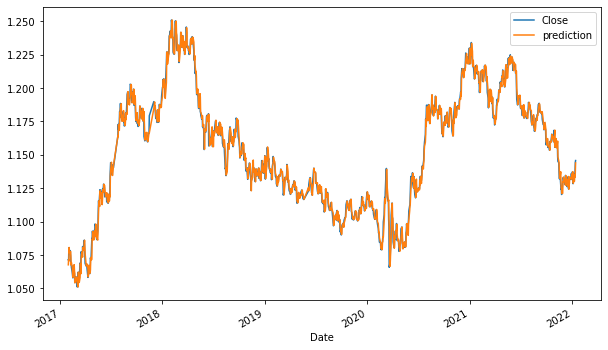

In [4]:
#對收盤價和預測值進行繪圖比較
data[['Close','prediction']].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

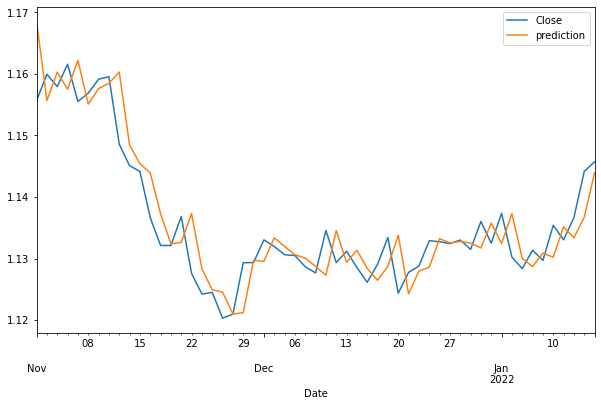

In [5]:
#從2021-11-01開始進行約3個月的走勢預測並與實際值進行比對
data[['Close','prediction']].loc['2021-11-01':].plot(figsize=(10,6))

In [6]:
#計算對數報酬
data['returns']=np.log(data['Close']/data['Close'].shift(1)).dropna()

In [7]:
#根據lag的值，針對報酬進行縱列進行平移操作
cols=[]
for lag in range(1,lags+1):
    col=f'lag_{lag}'
    data[col]=data['returns'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [8]:
#對預測進行方向分類，分為正負號(1, -1)
data['direction']=np.sign(data['returns']).astype(int)

In [9]:
#使用scikit-learn的OLS回歸實作
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [10]:
#使用對數報酬率進行迴歸
data['pos_ols_1']=model.fit(data[cols],data['returns']).predict(data[cols])

In [11]:
#將方向作為重要的因素做迴歸分析
data['pos_ols_2']=model.fit(data[cols],data['direction']).predict(data[cols])

In [12]:
data[['pos_ols_1','pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2017-02-14,0.000535,0.129415
2017-02-15,0.000039,0.106948
2017-02-16,0.000486,0.135793
2017-02-17,0.000341,0.081880
2017-02-20,0.000589,0.164209


In [13]:
#將實值的預測轉換為方向值(1-1)
data[['pos_ols_1','pos_ols_2']]=np.where(data[['pos_ols_1','pos_ols_2']]>0,1,-1)

In [14]:
#預測不同方向
data['pos_ols_2'].value_counts()

 1    704
-1    547
Name: pos_ols_2, dtype: int64

In [15]:
(data['pos_ols_1'].diff() !=0).sum()

633

In [16]:
(data['pos_ols_2'].diff() !=0).sum()

714

In [17]:
data['strat_ols_1']=data['pos_ols_1']*data['returns']

In [18]:
data['strat_ols_2']=data['pos_ols_2']*data['returns']

In [19]:
data[['returns','strat_ols_1','strat_ols_2']].sum().apply(np.exp)

returns        1.078872
strat_ols_1    1.397828
strat_ols_2    1.298924
dtype: float64

In [20]:
#顯示各種策略正確與錯誤預測數量
(data['direction']==data['pos_ols_1']).value_counts()

True     681
False    570
dtype: int64

In [21]:
#顯示各種策略正確與錯誤預測數量
(data['direction']==data['pos_ols_2']).value_counts()

True     675
False    576
dtype: int64

<AxesSubplot:xlabel='Date'>

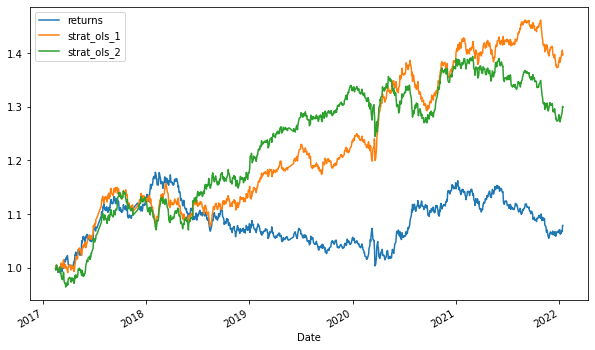

In [22]:
#隨著時間變動的歐元/美元回歸策略績效
data[['returns','strat_ols_1','strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10,6))